### Mount Drive && Install Timm if needed

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
!pip install timm

### Define Paths

In [2]:
from pathlib import Path

from fastai.vision.all import *
import pandas as pd
import numpy as np
import timm
from pathlib import Path

BASE_DIR = Path('/content/drive/MyDrive/Music_Genre_Classification/MagnaTagATune')
SPEC_DIR = BASE_DIR / 'spectrograms_v1'
MODELS_DIR = BASE_DIR / 'models'
MODELS_DIR.mkdir(parents=True, exist_ok=True)
BASE_DIR, SPEC_DIR

(Path('/content/drive/MyDrive/Music_Genre_Classification/MagnaTagATune'),
 Path('/content/drive/MyDrive/Music_Genre_Classification/MagnaTagATune/spectrograms_v1'))

### Splitting

In [3]:
chunks_path = BASE_DIR / 'mtat_spectrogram_chunks.csv'
df = pd.read_csv(chunks_path)
df.head(), df.shape

(                                                                                                  img_path  \
 0  /content/drive/MyDrive/Music_Genre_Classification/MagnaTagATune/spectrograms_v1/train/11276_chunk00.png   
 1  /content/drive/MyDrive/Music_Genre_Classification/MagnaTagATune/spectrograms_v1/train/11276_chunk01.png   
 2  /content/drive/MyDrive/Music_Genre_Classification/MagnaTagATune/spectrograms_v1/train/11276_chunk02.png   
 3  /content/drive/MyDrive/Music_Genre_Classification/MagnaTagATune/spectrograms_v1/train/11276_chunk03.png   
 4  /content/drive/MyDrive/Music_Genre_Classification/MagnaTagATune/spectrograms_v1/train/15813_chunk00.png   
 
                                  tags  split  
 0  female vocals woman foreign tribal  train  
 1  female vocals woman foreign tribal  train  
 2  female vocals woman foreign tribal  train  
 3  female vocals woman foreign tribal  train  
 4                   techno electronic  train  ,
 (86540, 3))

In [4]:
df['split'].value_counts()


,count
split,
train,69232
valid,8656
test,8652


In [7]:
# Split string tags -> list, then flatten
all_tags = df['tags'].str.split(' ').explode()
tag_counts = all_tags.value_counts()
tag_counts.head(20), tag_counts.tail(20)

(tags
 guitar        22184
 classical     18224
 vocal         17480
 no            16060
 male          14680
 slow          14188
 female        12960
 vocals        12772
 techno        11816
 strings       11132
 drums         11056
 rock          11032
 electronic    10076
 fast           9596
 voice          9548
 piano          9520
 beat           8308
 ambient        7824
 violin         7652
 singing        6952
 Name: count, dtype: int64,
 tags
 airy          264
 world         260
 eerie         260
 hop           256
 deep          256
 hip           256
 space         252
 light         248
 keyboard      248
 horn          236
 clapping      236
 disco         228
 orchestral    224
 old           220
 lol           216
 echo          216
 jungle        212
 bongos        208
 reggae        208
 monks         204
 Name: count, dtype: int64)

In [11]:
# Keep only train + valid for fastai's DataBlock
df_tv = df[df['split'] != 'test'].copy().reset_index(drop=True)

# Boolean column: True = valid, False = train
df_tv['is_valid'] = df_tv['split'] == 'valid'

df_tv['split'].value_counts(), df_tv['is_valid'].value_counts()


(split
 train    69232
 valid     8656
 Name: count, dtype: int64,
 is_valid
 False    69232
 True      8656
 Name: count, dtype: int64)

### Define SpecAugment Mask && Build Data block

In [12]:
from fastai.vision.all import *
import random

class SpecAugment(RandTransform):
    "Simple SpecAugment-like masking on spectrogram images (train only)."
    split_idx = 0   # 🔥 only apply on training

    def __init__(
        self,
        time_mask_frac=0.05,
        freq_mask_frac=0.05,
        n_time_masks=1,
        n_freq_masks=1,
        p=0.5,
        **kwargs
    ):
        super().__init__(p=p, **kwargs)
        self.time_mask_frac = time_mask_frac
        self.freq_mask_frac = freq_mask_frac
        self.n_time_masks = n_time_masks
        self.n_freq_masks = n_freq_masks

    def _apply_to_single(self, x:TensorImage):
        "Apply time/freq masks to a single image of shape (C,H,W)."
        c, h, w = x.shape

        # Frequency masks (horizontal bands)
        for _ in range(self.n_freq_masks):
            mask_height = int(self.freq_mask_frac * h)
            if mask_height < 1:
                continue
            f0 = random.randint(0, max(0, h - mask_height))
            x[:, f0:f0+mask_height, :] = 0.

        # Time masks (vertical bands)
        for _ in range(self.n_time_masks):
            mask_width = int(self.time_mask_frac * w)
            if mask_width < 1:
                continue
            t0 = random.randint(0, max(0, w - mask_width))
            x[:, :, t0:t0+mask_width] = 0.

        return x

    def encodes(self, x:TensorImage):
        # x can be (C,H,W) or (B,C,H,W)
        if x.ndim == 3:
            return self._apply_to_single(x)
        elif x.ndim == 4:
            for i in range(x.shape[0]):
                x[i] = self._apply_to_single(x[i])
            return x
        else:
            return x


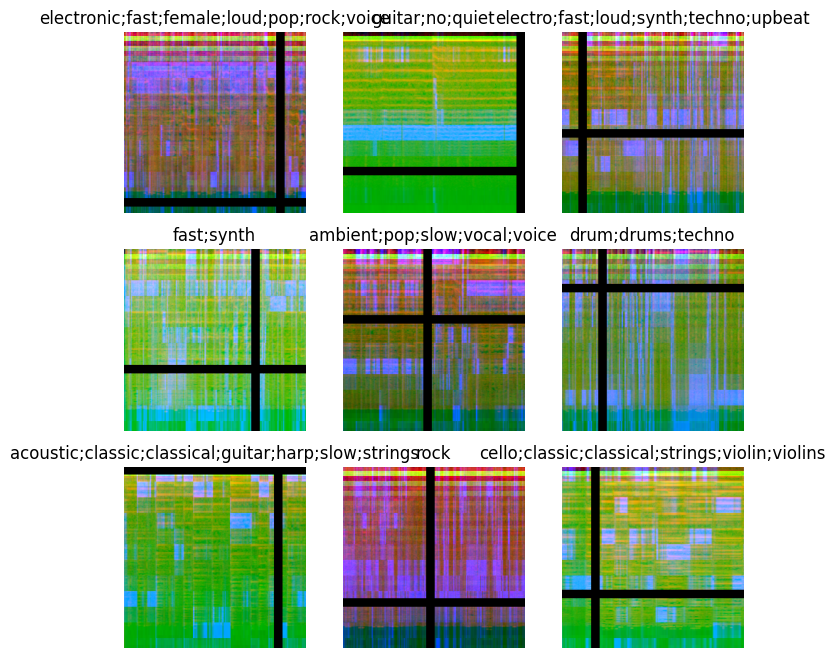

In [14]:
# Ensure img paths are strings
df_tv['img_path'] = df_tv['img_path'].astype(str)

dblock = DataBlock(
    blocks=(ImageBlock, MultiCategoryBlock),
    get_x=ColReader('img_path'),
    get_y=ColReader('tags', label_delim=' '),
    splitter=ColSplitter('is_valid'),   # <<-- use boolean column
    item_tfms=Resize(256),
    batch_tfms=[
        SpecAugment(
            time_mask_frac=0.05,
            freq_mask_frac=0.05,
            n_time_masks=1,
            n_freq_masks=1,
            p=0.5
        ),
        Normalize.from_stats(*imagenet_stats),
    ]
)

dls = dblock.dataloaders(df_tv, bs=32)
dls.show_batch(max_n=9, figsize=(8, 8))


### Train Model

In [15]:
learn = vision_learner(
    dls,
    "efficientnet_b2",
    metrics=[partial(accuracy_multi, thresh=0.5), F1ScoreMulti()]
)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/36.8M [00:00<?, ?B/s]

In [16]:
learn.fine_tune(10, base_lr=3e-4)


epoch,train_loss,valid_loss,accuracy_multi,f1_score,time
0,0.109731,0.096716,0.971492,0.027167,1:26:40


epoch,train_loss,valid_loss,accuracy_multi,f1_score,time
0,0.104635,0.092336,0.971801,0.034645,04:08
1,0.097200,0.088549,0.972292,0.045044,04:09
2,0.093181,0.085937,0.972473,0.055006,04:11
3,0.087382,0.083520,0.972826,0.062395,04:09
4,0.086641,0.082783,0.973024,0.068525,04:10
5,0.084277,0.081378,0.973209,0.073873,04:10
6,0.082281,0.081026,0.973192,0.071558,04:11
7,0.084071,0.080780,0.973349,0.076813,04:10
8,0.082741,0.080602,0.973366,0.074262,04:12
9,0.081476,0.080349,0.973387,0.077517,04:12


### Evaluation

In [17]:
learn.accumulate_metrics = True
preds, targs = learn.get_preds()

from sklearn.metrics import f1_score
import numpy as np

best_t = 0
best_f1 = 0

for t in np.linspace(0.1, 0.9, 17):
    f1 = f1_score(targs, preds > t, average='micro')
    if f1 > best_f1:
        best_f1 = f1
        best_t = t

best_t, best_f1


(np.float64(0.2), 0.4339946354783365)

### Save Model

In [18]:
MODELS_DIR = BASE_DIR / 'models'
MODELS_DIR.mkdir(parents=True, exist_ok=True)
learn.save(MODELS_DIR / 'effnet_b2_MagnaTagATune_v2')

# Full export (includes architecture + preprocessing)
learn.export(MODELS_DIR / 'effnet_b2_MagnaTagATune_v2.pkl')
MODELS_DIR

Path('/content/drive/MyDrive/Music_Genre_Classification/MagnaTagATune/models')

### Evaluate on Test dataset

In [5]:
def best_f1_threshold(preds, targs, start=0.1, end=0.9, steps=17):
    best_t, best_f1 = 0.0, 0.0
    for t in np.linspace(start, end, steps):
        f1 = f1_score(targs, preds > t, average='micro')
        if f1 > best_f1:
            best_f1, best_t = f1, t
    return float(best_t), float(best_f1)

In [8]:
from pathlib import Path
import pandas as pd
import numpy as np

from fastai.vision.all import *
from sklearn.metrics import f1_score

learn_b2 = load_learner(MODELS_DIR / 'effnet_b2_MagnaTagATune_v2.pkl')
learn_b2



/usr/local/lib/python3.12/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


In [11]:
df_test = df[df['split'] == 'test'].copy().reset_index(drop=True)
df_test['img_path'] = df_test['img_path'].astype(str)
len(df_test), df_test.head()


(8652,
                                                                                                  img_path  \
 0  /content/drive/MyDrive/Music_Genre_Classification/MagnaTagATune/spectrograms_v1/test/57096_chunk00.png   
 1  /content/drive/MyDrive/Music_Genre_Classification/MagnaTagATune/spectrograms_v1/test/57096_chunk01.png   
 2  /content/drive/MyDrive/Music_Genre_Classification/MagnaTagATune/spectrograms_v1/test/57096_chunk02.png   
 3  /content/drive/MyDrive/Music_Genre_Classification/MagnaTagATune/spectrograms_v1/test/57096_chunk03.png   
 4  /content/drive/MyDrive/Music_Genre_Classification/MagnaTagATune/spectrograms_v1/test/40573_chunk00.png   
 
                                      tags split  
 0  guitar slow piano no vocals quiet harp  test  
 1  guitar slow piano no vocals quiet harp  test  
 2  guitar slow piano no vocals quiet harp  test  
 3  guitar slow piano no vocals quiet harp  test  
 4                            male spanish  test  )

In [12]:
test_dl_b2 = learn_b2.dls.test_dl(df_test, with_labels=True)
preds_b2, targs_b2 = learn_b2.get_preds(dl=test_dl_b2)
preds_b2.shape, targs_b2.shape


(torch.Size([8652, 145]), torch.Size([8652, 145]))

In [13]:
best_t_b2, best_f1_b2 = best_f1_threshold(preds_b2.numpy(), targs_b2.numpy())
best_t_b2, best_f1_b2


(0.2, 0.4341850349087985)

In [14]:
fixed_t = 0.2
f1_fixed_b2 = f1_score(targs_b2, preds_b2 > fixed_t, average='micro')
fixed_t, f1_fixed_b2


(0.2, 0.4341850349087985)